# Traininng:

Please refer to the repo: https://github.com/open-mmlab/mmdetection.

If you have it cloned, the first step is to navigate to the htc_r50_fpn_1x_coco.py file in `mmdetection/configs/htc/htc_r50_fpn_1x_artifact.py`. Then, please change the file to the following:

In [ ]:
_base_ = './htc_r50_fpn_1x_coco.py'

# 1. Modify dataset classes
classes = ('artefact',)

# 2. Update dataset paths
data_root = '/Users/jbm/Documents/DSAN_6500/WatchdogAI/data_artifacts/'
# data = dict(
#     samples_per_gpu=2,
#     workers_per_gpu=2,
#     train=dict(
#         type='CocoDataset',
#         ann_file=data_root + 'train/_annotations.coco.json',
#         img_prefix=data_root + 'train/',
#         classes=classes
#     ),
#     val=dict(
#         type='CocoDataset',
#         ann_file=data_root + 'valid/_annotations.coco.json',
#         img_prefix=data_root + 'valid/',
#         classes=classes
#     ),
#     test=dict(
#         type='CocoDataset',
#         ann_file=data_root + 'test/_annotations.coco.json',
#         img_prefix=data_root + 'test/',
#         classes=classes
#     )
# )

train_dataloader = dict(
    batch_size=16,
    num_workers=4,
    persistent_workers=True,
    sampler=dict(type='DefaultSampler', shuffle=True),
    batch_sampler=dict(type='AspectRatioBatchSampler'),
    dataset=dict(
        type='CocoDataset',
        data_root=data_root,
        ann_file='train/_annotations.coco.json',
        data_prefix=dict(img='train/'),
        metainfo=dict(classes=classes),
        filter_cfg=dict(filter_empty_gt=False),
        pipeline=[
            dict(type='LoadImageFromFile'),
            dict(type='LoadAnnotations', with_bbox=True, with_mask=False),
            dict(type='RandomFlip', prob=0.5),

            # AutoAugment with scale changes — simulates variable resolution
            dict(
                type='AutoAugment',
                policies=[
                    [dict(type='Resize', scale=(1333, 640), keep_ratio=True)],
                    [dict(type='Resize', scale=(1333, 800), keep_ratio=True)],
                    [dict(type='Resize', scale=(1333, 960), keep_ratio=True)]
                ]
            ),

            # Mild brightness/contrast jitter — simulates different lighting
            dict(
                type='PhotoMetricDistortion',
                brightness_delta=16,
                contrast_range=(0.9, 1.1),
                saturation_range=(0.95, 1.05),
                hue_delta=4
            ),

            dict(type='PackDetInputs')
        ]
        # pipeline=[
        #     dict(type='LoadImageFromFile'),
        #     dict(type='LoadAnnotations', with_bbox=True, with_mask=False),
        #     dict(type='Resize', scale=(1333, 800), keep_ratio=True),
        #     dict(type='RandomFlip', prob=0.5),
        #     dict(type='PhotoMetricDistortion'),
        #     dict(type='PackDetInputs')
        # ]
    )
)

val_dataloader = dict(
    batch_size=1,
    num_workers=2,
    persistent_workers=True,
    sampler=dict(type='DefaultSampler', shuffle=False),
    dataset=dict(
        type='CocoDataset',
        data_root=data_root,
        ann_file='valid/_annotations.coco.json',
        data_prefix=dict(img='valid/'),
        metainfo=dict(classes=classes),
        filter_cfg=dict(filter_empty_gt=False),
        pipeline=[
            dict(type='LoadImageFromFile'),
            dict(type='Resize', scale=(1333, 800), keep_ratio=True),
            dict(type='LoadAnnotations', with_bbox=True, with_mask=False),
            dict(
                type='PackDetInputs',
                meta_keys=('img_id', 'img_path', 'ori_shape', 'img_shape', 'scale_factor'))
        ]
    )
)
test_dataloader = dict(
    batch_size=1,
    num_workers=2,
    persistent_workers=True,
    sampler=dict(type='DefaultSampler', shuffle=False),
    dataset=dict(
        type='CocoDataset',
        data_root=data_root,
        ann_file='test/_annotations.coco.json',
        data_prefix=dict(img='test/'),
        metainfo=dict(classes=classes),
        filter_cfg=dict(filter_empty_gt=False),  # for safety
        pipeline=[
            dict(type='LoadImageFromFile'),
            dict(type='Resize', scale=(1333, 800), keep_ratio=True),
            dict(type='LoadAnnotations', with_bbox=True, with_mask=False),
            dict(
                type='PackDetInputs',
                meta_keys=('img_id', 'img_path', 'ori_shape', 'img_shape', 'scale_factor'))
        ]
    )
)

val_evaluator = dict(
    type='CocoMetric',
    ann_file=data_root + 'valid/_annotations.coco.json',
    metric=['bbox']
)

test_evaluator = val_evaluator

# 3. Adjust model to match 1 class
model = dict(
    backbone=dict(
    frozen_stages=1 
    ),
    roi_head=dict(
        bbox_head=[
            dict(type='Shared2FCBBoxHead', num_classes=1),
            dict(type='Shared2FCBBoxHead', num_classes=1),
            dict(type='Shared2FCBBoxHead', num_classes=1)
        ],
        mask_head=None,
        semantic_roi_extractor=None,
        semantic_head=None
    ),

    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[.0, .0, .0, .0],
            target_stds=[1.0, 1.0, 1.0, 1.0]),
        loss_cls=dict(
            type='CrossEntropyLoss', use_sigmoid=True, loss_weight=1.0),
        loss_bbox=dict(type='SmoothL1Loss', beta=1.0 / 9.0, loss_weight=1.0),
        test_cfg=dict(
            nms_pre=2000,
            max_per_img=1000,
            nms=dict(type='nms', iou_threshold=0.7),
            min_bbox_size=0
        )
    ),

    test_cfg=dict(
        rpn=dict(
            nms_pre=2000,
            max_per_img=1000,
            nms=dict(type='nms', iou_threshold=0.7),
            min_bbox_size=0
        ),
        rcnn=dict(
            score_thr=0.05,
            nms=dict(type='nms', iou_threshold=0.5),
            max_per_img=100
        )
    ),

    train_cfg=dict(
        rpn=dict(
            assigner=dict(
                type='MaxIoUAssigner',
                pos_iou_thr=0.7,
                neg_iou_thr=0.3,
                min_pos_iou=0.3,
                ignore_iof_thr=-1
            ),
            sampler=dict(
                type='RandomSampler',
                num=256,
                pos_fraction=0.5,
                neg_pos_ub=-1,
                add_gt_as_proposals=False
            ),
            allowed_border=0,
            pos_weight=-1,
            debug=False,
            nms=dict(type='nms', iou_threshold=0.7),
            nms_pre=2000,
            max_per_img=1000,
            min_bbox_size=0
        ),
        rpn_proposal=dict(
            nms_pre=2000,
            max_per_img=1000,
            nms=dict(type='nms', iou_threshold=0.7),
            min_bbox_size=0
        ),
        rcnn=[
            dict(
                assigner=dict(
                    type='MaxIoUAssigner',
                    pos_iou_thr=0.5,
                    neg_iou_thr=0.5,
                    min_pos_iou=0.5,
                    ignore_iof_thr=-1),
                sampler=dict(
                    type='RandomSampler',
                    num=512,
                    pos_fraction=0.25,
                    neg_pos_ub=-1,
                    add_gt_as_proposals=True),
                mask_size=28,
                pos_weight=-1,
                debug=False
            ) for _ in range(3)
        ]
    )
)


model['train_cfg'] = dict(
    rpn=dict(
        nms=dict(type='nms', iou_threshold=0.7)
    )
)


runner = dict(
    type='IterBasedTrainLoop',
    max_iters=10000,
    val_interval=50 
)


val_cfg = dict(type='ValLoop')
test_cfg = dict(type='TestLoop')

# Add early stopping hook
custom_hooks = [
    dict(
        type='EarlyStoppingHook',
        monitor='coco/bbox_mAP',
        rule='greater',  # because higher mAP is better
        patience=200 
    )
]

custom_hooks += [
    dict(
        type='DetVisualizationHook',
        interval=150,  # do it every X iterations
        draw=True,
        test_out_dir='work_dirs/htc_r50_artifact/vis_results'  # saves images here
    )
]

default_hooks = dict(
    checkpoint=dict(
        type='CheckpointHook',
        interval=1000,  # How often to save
        save_best='coco/bbox_mAP',  # Metric to track for best
        rule='greater',  # Maximize the metric
        max_keep_ckpts=1  # Only keep best to save space
    ),
    logger=dict(type='LoggerHook', interval=50)
)

visualizer = dict(
    type='DetLocalVisualizer',
    vis_backends=[dict(type='LocalVisBackend')],
    name='vis'
)

# 5. Set working directory
work_dir = './work_dirs/htc_r50_artifact'
load_from = 'checkpoints/htc_r50.pth'

This file above makes all the setup for the training followed by us.

Then, our environment for training (since it was outsourced) was setup with the following:

- python 3.10
- Torch torchvision torchaudio -- cuda compatible
- `cd mmdetection` (if the repo is cloned)
- `pip install -e .`

Then, we trained the model by running the following command:

```
python tools/train.py configs/htc/htc_r50_fpn_1x_artifact.py
```

Finally, to visualize the training, we ran the following:

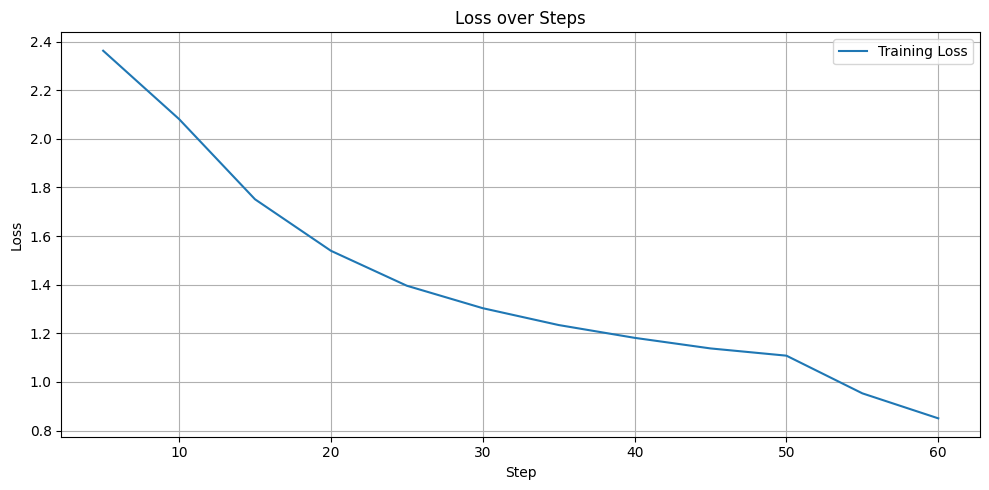

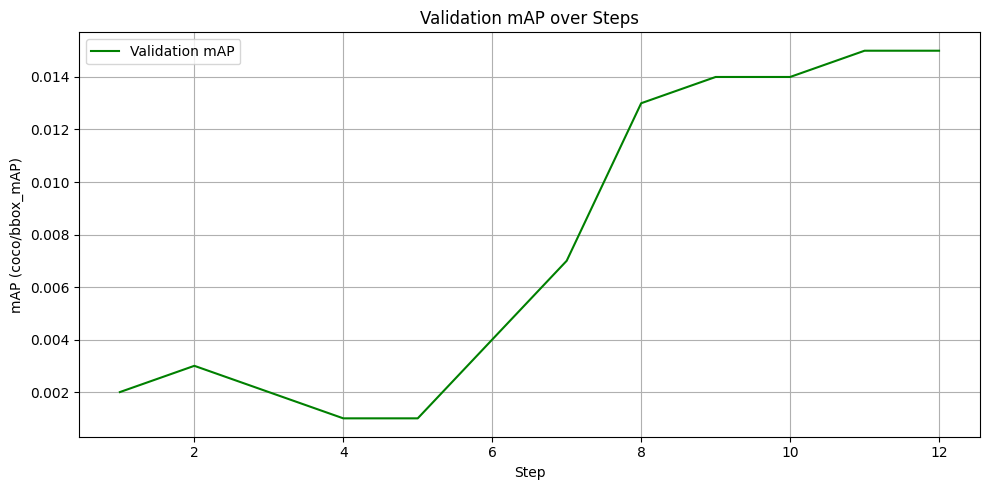

In [7]:
import json
import matplotlib.pyplot as plt

scalars_path = "../htc_r50_artifact_final/20250424_163117/vis_data/scalars.json"

iters = []
losses = []
mAPs = []

with open(scalars_path) as f:
    for line in f:
        try:
            entry = json.loads(line)
        except json.JSONDecodeError:
            continue
        if 'loss' in entry:
            iters.append(entry['step'])  # or entry['iter']
            losses.append(entry['loss'])
        if 'coco/bbox_mAP' in entry:
            mAPs.append((entry['step'], entry['coco/bbox_mAP']))

# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(iters, losses, label="Training Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Loss over Steps")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("loss_curve.png")
plt.show()

# Plot mAP
if mAPs:
    map_iters, map_vals = zip(*mAPs)
    plt.figure(figsize=(10, 5))
    plt.plot(map_iters, map_vals, label="Validation mAP", color='green')
    plt.xlabel("Step")
    plt.ylabel("mAP (coco/bbox_mAP)")
    plt.title("Validation mAP over Steps")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig("map_curve.png")
    plt.show()
else:
    print("No mAP values found in scalars.json")


As you can see, the training is improving steadily, and the mAP is increasing. Even though the training has not plateaued yet, we can see that the model is learning. We had to stop it due to our computational and time constraints. However, this model could be improved further by training it for longer.





